In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from datetime import datetime, timedelta
import cartopy.crs as ccrs

from derivatives import first_derivative_lon, first_derivative_lat, second_derivative_lon, second_derivative_lat
from derivatives import laplacian

from planet import Planet

In [12]:
# DAY=60*60*24
# INSOLATION=1370
# SIGMA=5.67E-8
# EPSILON=0.75
# AIR_DENSITY=1.3
# SPECIFIC_GAS_AIR=287
# PLANET_RADIUS=6.4E6
# NU=1.5E-5

# THERMAL_DIFFUSIVITY=2.14E-5
# CIRCUMFERENCE=2*np.pi*PLANET_RADIUS
# CIRCLE=np.pi*PLANET_RADIUS**2
# SPHERE=4*np.pi*PLANET_RADIUS**2

In [13]:
configuration = {
    "planetRadius": 6.4E6,
    "insolation": 1370,
    "sigma": 5.67E-8,
    "epsilon": 0.75,
    "airDensity": 1.3,
    "specificGasAir": 287,
    "heatCapacityEarth": 2.093E8,
    "heatCapacityAtmosphere": 1.02E7,
    "thermalDiffusivityAir": 20E-6,
    "thermalDiffusivityOcean": 1.5E-6,
    "nu":1.5E-5,
    "resolution":3
}

In [14]:
def solar_radiation(insolation, lat, lon, t, reference_start_time):
    """
    Calculate the solar irradiance based on insolation, latitude, longitude, and time.

    Parameters:
    insolation (float): Maximum solar radiation at the top of the atmosphere (e.g., solar constant ~1361 W/m²).
    lat (array-like): Array of latitudes in degrees.
    lon (array-like): Array of longitudes in degrees (0 to 360, positive east).
    t (float): Time parameter in seconds since reference_start_time.
    reference_start_time (datetime): The reference start time.

    Returns:
    ndarray: Solar irradiance in W/m² for each latitude and longitude point.
    """
    # Constants
    
    t = 60000
    DEG_TO_RAD = np.pi / 180
    SECONDS_PER_DAY = 86400  # Number of seconds in a day

    # Calculate the current time from seconds since the reference
    current_time = reference_start_time + timedelta(seconds=t)
    day_of_year = current_time.timetuple().tm_yday
    time_of_day_seconds = current_time.hour * 3600 + current_time.minute * 60 + current_time.second

    # Calculate solar declination (approximate formula)
    declination = 23.45 * np.sin(DEG_TO_RAD * (360 / 365 * (day_of_year - 81))) * DEG_TO_RAD  # in radians

    # Convert latitude to radians
    lat_rad = np.deg2rad(lat)

    # Ensure longitude ranges from 0° to 360°
    lon_deg = np.mod(lon, 360)

    # Create meshgrid for latitudes and longitudes
    lat_rad_mesh, lon_deg_mesh = np.meshgrid(lat_rad, lon_deg, indexing='ij')

    # Calculate local solar time for each point
    time_hours = (time_of_day_seconds % SECONDS_PER_DAY) / 3600.0  # Convert time to hours (0 to 24)
    solar_time = (time_hours + lon_deg_mesh / 15.0) % 24  # Local solar time in hours

    # Calculate hour angle in radians
    hour_angle = DEG_TO_RAD * 15 * (solar_time - 12)  # Hour angle in radians

    # Calculate solar zenith angle
    zenith_angle = np.arccos(
        np.sin(lat_rad_mesh) * np.sin(declination) +
        np.cos(lat_rad_mesh) * np.cos(declination) * np.cos(hour_angle)
    )

    # Solar irradiance proportional to cos(zenith_angle)
    solar_irradiance = insolation * np.cos(zenith_angle)

    # Set nighttime irradiance to zero
    solar_irradiance[solar_irradiance < 0] = 0

    return solar_irradiance


In [15]:
def update_or_create_plot(model, fig=None, spinCoord=0):
    """
    Update or create a plot for the atmospheric model.

    Parameters:
    model: The atmospheric model object.
    fig: A matplotlib figure instance to update. If None, a new figure is created.
    axes: A list of axes instances to update. If None, new axes are created.
    """

    if fig is None:
        # Create new figure and axes if not provided
        fig, axes = plt.subplots(2, 2, figsize=(12, 12), 
                                 subplot_kw={'projection': ccrs.Orthographic(-10, spinCoord%360)})

    lonPlot, latPlot = np.meshgrid(model.lon, model.lat)

    fig.clf() 

    ax0 = fig.add_subplot(2, 2, 1, projection=ccrs.Orthographic(spinCoord%360,30))
    ax1 = fig.add_subplot(2, 2, 2, projection=ccrs.Orthographic(spinCoord%360,30))
    ax2 = fig.add_subplot(2, 2, 3)
    ax3 = fig.add_subplot(2, 2, 4)

    axes = fig.get_axes()
    
    for ax in axes:
        ax.clear()  # Clear existing content

    # Update contour plots
    axes[0].contourf(lonPlot, latPlot, model.temperaturePlanet, cmap='viridis', transform=ccrs.PlateCarree())
    axes[1].contourf(lonPlot, latPlot, model.temperatureAtmosphere, cmap='viridis', transform=ccrs.PlateCarree())

    # Update quiver plot for wind vectors
    axes[1].quiver(lonPlot[::3,::3], latPlot[::3,::3], model.u[::3, ::3], 
                      model.v[::3, ::3], color='white', transform=ccrs.PlateCarree())

    # Update line plots for zonal averages
    axes[2].plot(np.mean(model.temperaturePlanet, axis=1),model.lat, 'k-')
    axes[3].plot(np.mean(model.temperatureAtmosphere, axis=1),model.lat, 'k-')

    # Set titles and labels
    axes[0].set_title(f'Temperature on Planet Surface: Time {model.time}, {model.t}')
    axes[1].set_title('Temperature in Atmosphere')
    axes[2].set_title('Zonal Average Temperature on Planet Surface')
    axes[3].set_title('Zonal Average Temperature in Atmosphere')

    for ax in [axes[0], axes[1]]:
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.coastlines()

    plt.pause(0.1) 
    plt.draw()
    plt.show()


In [21]:
class atmosphericModel(Planet):

    def __init__(self, configuration):
        super().__init__(configuration)
        self.initTracers()

        self.dt = 60*5
        self.t = 0
        self.reference_start_time = datetime(2023, 1, 1, 0, 0, 0)
        self.day = 86400
        print(f"dt set to {self.dt}. Use <model name>['dt'] = <timestep> to change it.")

    def initTracers(self):
        self.temperaturePlanet = np.zeros((self.nlat, self.nlon)) + 273.15 + np.random.uniform(-1, 1,size=(self.nlat, self.nlon))
        self.temperatureAtmosphere = np.zeros((self.nlat, self.nlon)) + 273.15 + np.random.uniform(-1, 1,size=(self.nlat, self.nlon))
        self.airPressure = np.zeros((self.nlat, self.nlon))
        self.airDensity = np.zeros_like(self.airPressure) + 1.3
        self.u = np.zeros((self.nlat, self.nlon)) + np.random.uniform(-0.02, 0.02,size=(self.nlat, self.nlon))
        self.v = np.zeros((self.nlat, self.nlon)) + np.random.uniform(-0.02, 0.02,size=(self.nlat, self.nlon))
        self.albedo = (np.zeros_like(self.u) + 0.3) #* np.random.uniform(-0.02, 0.02,size=(self.nlat, self.nlon))
        print("Initialized tracers")
        
    def updateSolarRadiation(self):

        self.temperaturePlanet += self.dt * (
            + (
                (1-self.albedo)
                * solar_radiation(
                    insolation=self.insolation,
                    lat=self.lat,
                    lon=self.lon,
                    t=self.t,
                    reference_start_time=self.reference_start_time
                )
            )
            + self.epsilon*self.sigma*self.temperatureAtmosphere**4
            - self.sigma*self.temperaturePlanet**4
            ) / (self.heatCapacityEarth)

        self.temperatureAtmosphere += self.dt*(
            - (
                2 * self.epsilon
                * self.sigma
                * self.temperatureAtmosphere**4
            )
            + (
                self.epsilon
                * self.sigma
                * self.temperaturePlanet**4
            )
            ) / (self.heatCapacityAtmosphere) 
    
    def updateVelocityGeostrophic(self):
        self.u += -self.dt*(
            + (1/self.airDensity)*first_derivative_lon(self.airPressure, self.dx)
            - self.coriolis*self.v)
        self.v += -self.dt*(
            + (1/self.airDensity)*first_derivative_lat(self.airPressure, self.dy)
            + self.coriolis*self.u)

    def updateVelocity(self):

        self.u += -self.dt*(
            + self.u*first_derivative_lon(self.u, self.dx)
            + self.v*first_derivative_lat(self.u, self.dy)
            + self.nu*laplacian(self.u, self.dx, self.dy)
            + (1/self.airDensity)*first_derivative_lon(self.airPressure, self.dx)
            - self.coriolis*self.v
          )

        self.v += -self.dt*(
            + self.u*first_derivative_lon(self.v, self.dx)
            + self.v*first_derivative_lat(self.v, self.dy)
            + self.nu*laplacian(self.v, self.dx, self.dy)
            + (1/self.airDensity)*first_derivative_lat(self.airPressure, self.dy)
            + self.coriolis*self.u
          )

    def advectField(self, field):
        field += -self.dt * (
        + first_derivative_lon(field*self.u, self.dx) 
        + first_derivative_lat(field*self.v, self.dy)
        )
        return field

    def heatEquation(self, tField, thermalDiffusivity):
        tField += self.dt * (
            + second_derivative_lon(tField, self.dx)
            + second_derivative_lat(tField, self.dy)
        )
        return tField
  
    def apply_neumann_bc_lat_ghosts(self, var):
        """
        Imposes zero-gradient boundary conditions in lat direction
        with 1 ghost cell on top (index 0) and bottom (index -1).
        Physical domain is var[1 : -1, :].

        Enforces var[1] = var[2] for top boundary,
        and var[-2] = var[-3] for bottom boundary.
        Then ghost rows (0, -1) can copy from the boundary (or do something else).
        """

        # Fill ghost rows from the boundary or interior
        var[1, :] = var[2, :]    # top ghost = top boundary
        var[0, :] = var[2, :]     # top ghost = top boundary
        var[-2, :] = var[-3, :]  # bottom ghost = bottom boundary
        var[-1, :] = var[-3, :]  # bottom ghost = bottom boundary
        return var


    def timeStep(self):

        if self.t < (10*86400):
            self.dt = 60
        else:
            self.dt = 120
    
        self.updateSolarRadiation()

        self.airPressure = self.airDensity*self.temperatureAtmosphere*self.specificGasAir

        self.updateVelocity()
        
        self.u[-5:,:] = 0
        self.v[-5:,:] = 0
        self.u[:5,:] = 0
        self.v[:5,:] = 0
        
        for i in range(0,5):
            self.temperaturePlanet[i,:] =  self.temperaturePlanet[5,0]
            self.temperaturePlanet[-i,:] =  self.temperaturePlanet[-5,0]
            self.temperatureAtmosphere[i,:] =  self.temperatureAtmosphere[5,0]
            self.temperatureAtmosphere[-i,:] =  self.temperatureAtmosphere[-5,0]


        # self.u = self.apply_neumann_bc_lat_ghosts(self.u)
        # self.v = self.apply_neumann_bc_lat_ghosts(self.v)
        
        ### Advection and diffusion
        ## Advect
        
        # self.temperaturePlanet = self.advectField(self.temperaturePlanet)
        # The atmosphere is advected by wind

        self.temperatureAtmosphere = self.advectField(self.temperatureAtmosphere)
        
        #self.airPressure = self.advectField(self.airPressure)
        
        # Diffusion occurs in the ocean

        self.temperaturePlanet = self.heatEquation(self.temperaturePlanet, self.thermalDiffusivityOcean)
        self.temperatureAtmosphere = self.heatEquation(self.temperatureAtmosphere, self.thermalDiffusivityAir)

        self.temperaturePlanet = self.apply_neumann_bc_lat_ghosts(self.temperaturePlanet)
        self.temperatureAtmosphere = self.apply_neumann_bc_lat_ghosts(self.temperatureAtmosphere)
        self.airPressure = self.apply_neumann_bc_lat_ghosts(self.airPressure)
        
        self.t += self.dt  
        self.time = self.reference_start_time + timedelta(seconds=self.t)

In [22]:
1968000 > 20*86400

True

In [23]:
model = atmosphericModel(configuration=configuration)

Initialized tracers
dt set to 300. Use <model name>['dt'] = <timestep> to change it.


In [24]:
model.timeStep()

In [25]:
time = model.t
n = 1500000


for i in (range(0, n)):
    time = model.t
    print(time, f"{i/n*100:2f}", end="\r")
    _ = model.timeStep()

/var/folders/38/z0l88jxs5cxc27_d0dp0r78c0000gn/T/ipykernel_55559/2704614366.py:49: RuntimeWarning: overflow encountered in power
  * self.temperaturePlanet**4
/Users/boergel/Documents/work/climateoftheearth/additional/simpleClimateModel/derivatives.py:17: RuntimeWarning: invalid value encountered in subtract
  return (x_shifted_plus_one - x_shifted_minus_one) / (2 * dx)
/Users/boergel/Documents/work/climateoftheearth/additional/simpleClimateModel/derivatives.py:33: RuntimeWarning: invalid value encountered in subtract
  derivative = (x_shifted_plus_one - x_shifted_minus_one) / (2 * dy)
/var/folders/38/z0l88jxs5cxc27_d0dp0r78c0000gn/T/ipykernel_55559/2704614366.py:72: RuntimeWarning: invalid value encountered in add
  + self.u*first_derivative_lon(self.v, self.dx)
/var/folders/38/z0l88jxs5cxc27_d0dp0r78c0000gn/T/ipykernel_55559/2704614366.py:81: RuntimeWarning: overflow encountered in multiply
  + first_derivative_lon(field*self.u, self.dx)
/var/folders/38/z0l88jxs5cxc27_d0dp0r78c0000gn

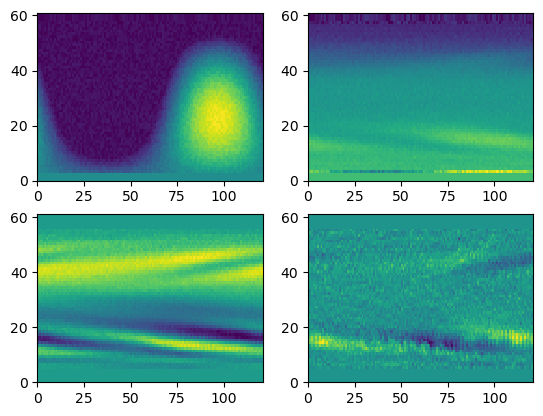

In [77]:
f, ax = plt.subplots(2,2)
ax = ax.ravel()
ax[0].pcolor(model.temperaturePlanet[:,:])
ax[1].pcolor(model.temperatureAtmosphere[:,:])
ax[2].pcolor(model.u[:,:])
ax[3].pcolor(model.v[:,:])


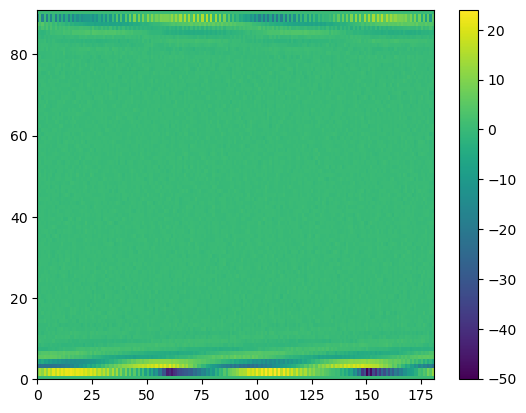

In [11]:
plt.pcolor(model.u[:,:])
plt.colorbar()

In [11]:
model.t

1076000

In [ ]:
resolution = 3
dt = 60

lat = np.arange(-90, 91, resolution)
lon = np.arange(0,361, resolution)

nlat = len(lat)
nlon = len(lon)
coriolis = np.zeros(nlat)

heatCapacityEarth= 1E7
heatCapacityAtmosphere= 1E7

# we assume a sphere, hence
dy = CIRCUMFERENCE/nlat
dx = CIRCUMFERENCE/nlat*np.cos(lat*np.pi/180)

for i in range(nlat):
    coriolis[i] = 1.45842E-4*np.sin(lat[i]*np.pi/180)

t=0

In [ ]:
earth = Planet(configuration=configuration)

In [ ]:
model = atmosphericModel(configuration=configuration)

Initialized tracers
dt set to 300. Use <model name>['dt'] = <timestep> to change it.


In [ ]:
TemperaturePlanet = np.zeros((nlat, nlon)) + 273.15
TemperatureAtmosphere = np.zeros((nlat, nlon)) + 273.15
AirPressure = np.zeros((nlat, nlon))
AIR_DENSITY = np.zeros_like(AirPressure)+1.3
u = np.zeros((nlat, nlon))+0.01
v = np.zeros((nlat, nlon))+0.01
albedo = np.zeros_like(u) + 0.3

albedo_variance = 0.02
for i in range(nlat):
    for j in range(nlon):
        albedo[i, j] += albedo_variance*np.random.uniform(-albedo_variance, albedo_variance)

In [ ]:
lonPlot, latPlot = np.meshgrid(lon, lat)

In [ ]:
u_prev = np.zeros_like(model.u)
u_model = np.zeros_like(model.u)

In [ ]:
def first_derivative_lon(x, lat, lon, dx):
    if lon == 0:
        return (x[lat, lon+1] - x[lat, -1]) / (2*dx)
    elif lon == x.shape[1] - 1:
        return (x[lat, 0] - x[lat, lon-1]) / (2*dx)
    else:
        return (x[lat, lon+1] - x[lat, lon-1]) / (2*dx)

In [ ]:
for latPoint in np.arange(1,model.nlat-1):
        for lonPoint in np.arange(model.nlon):
                u_prev[latPoint, lonPoint] = model.u[latPoint, lonPoint] - model.dt*(
                    # + model.u[latPoint, lonPoint]*first_derivative_lon(model.u, latPoint, lonPoint, model.dx[latPoint, lonPoint])
                    #  + model.v[latPoint, lonPoint]*first_derivative_lat(model.u, latPoint, lonPoint, model.dy[latPoint, lonPoint])
                   # + model.nu*laplacian(model.u, latPoint, lonPoint, model.dx[latPoint, lonPoint], model.dy[latPoint, lonPoint]))
                     + 1/model.airDensity[latPoint, lonPoint]*first_derivative_lon(model.airPressure, latPoint, lonPoint, model.dx[latPoint, lonPoint]))
                #     - model.coriolis[latPoint, lonPoint]*model.v[latPoint, lonPoint])

In [ ]:
from derivatives import first_derivative_lon, first_derivative_lat, second_derivative_lon, second_derivative_lat, laplacian

In [ ]:
u_model = model.u -model.dt*((1/model.airDensity)*first_derivative_lon(model.airPressure, model.dx))

In [ ]:
u_model = model.u -model.dt*(
    + model.u*first_derivative_lon(model.u, model.dx)
    + model.v*first_derivative_lat(model.u, model.dy)
   # + model.nu*laplacian(model.u, model.dx, model.dy)
    + (1/model.airDensity)*first_derivative_lon(model.airPressure, model.dx)
    - model.coriolis*model.v
    )

In [ ]:
f, ax = plt.subplots(1,2)
axplot = ax[0].pcolor(u_model)
ax[1].pcolor(u_prev)
f.colorbar(axplot)

In [ ]:
plt.pcolor(u_model-u_prev)
plt.colorbar()

In [ ]:
def first_derivative_lon(x, lat, lon, dx):
    if lon == 0:
        return (x[lat, lon+1] - x[lat, -1]) / (2*dx)
    elif lon == x.shape[1] - 1:
        return (x[lat, 0] - x[lat, lon-1]) / (2*dx)
    else:
        return (x[lat, lon+1] - x[lat, lon-1]) / (2*dx)

def second_derivative_lon(x, lat, lon, dx):
    if lon == 0:
        return (x[lat, lon+1] - 2*x[lat, lon] + x[lat, -1]) / dx**2
    elif lon == x.shape[1] - 1:
        return (x[lat, 0] - 2*x[lat, lon] + x[lat, lon-1]) / dx**2
    else:
        return (x[lat, lon+1] - 2*x[lat, lon] + x[lat, lon-1]) / dx**2

def first_derivative_lat(x, lat, lon, dy):
    if lat == 0 or lat == x.shape[0] - 1:
        return 0  # Or implement a different scheme
    return (x[lat+1, lon] - x[lat-1, lon]) / (2*dy)

def first_derivative_lat(x, lat, lon, dy):
    num_lats = x.shape[0]

    if dy == 0:
        raise ValueError("dy cannot be zero.")

    # Higher-order difference at the poles
    if lat == 0:
        # Forward difference using four points
        return (-3*x[lat, lon] + 4*x[lat+1, lon] - x[lat+2, lon]) / (2*dy)
    elif lat == 1:
        # Modified forward difference for the second point
        return (x[lat+1, lon] - x[lat-1, lon] + 4*x[lat, lon] - x[lat+2, lon]) / (3*dy)
    elif lat == num_lats - 2:
        # Modified backward difference for the second to last point
        return (x[lat-2, lon] - 4*x[lat-1, lon] + x[lat+1, lon] + x[lat, lon]) / (3*dy)
    elif lat == num_lats - 1:
        # Backward difference using four points
        return (x[lat-2, lon] - 4*x[lat-1, lon] + 3*x[lat, lon]) / (2*dy)
    else:
        # Central difference for other points
        return (x[lat-2, lon] - 8*x[lat-1, lon] + 8*x[lat+1, lon] - x[lat+2, lon]) / (12*dy)

def second_derivative_lat(x, lat, lon, dy):
    if lat == 0 or lat == x.shape[-2] - 1:
        return 0  # Handle the boundary conditions
    return (x[lat+1, lon] - 2 * x[lat, lon] + x[lat-1, lon]) / (dy**2)

def laplacian(x, lat, lon, dx, dy):
    return second_derivative_lon(x, lat, lon, dx) + second_derivative_lat(x, lat, lon, dy)

For the velocity we have the NSE:

$$ du/dt + (u \cdot \nabla)u +\nu \nabla^2 u = -1/\rho \nabla p + g $$



$$ \partial_t u = - u\cdot\partial_x u - v\cdot \partial_y u - \nu \partial_{xx}u - 1/\rho \partial_x p + f v$$
$$ \partial_t v = - u\cdot\partial_x v - v\cdot \partial_y v - \nu \partial_{yy}v - 1/\rho \partial_y p - f u$$

In [ ]:
plot=True

def add_zonal_average_plots(ax, data, latitudes, cmap, levels):
    zonal_avg = np.mean(data, axis=1)  # calculate zonal average
    ax.plot(zonal_avg, latitudes, color='black')  # plot zonal average
    ax.set_ylim(-90, 90)  # set y limits to latitude range
    ax.set_xlim(levels[0], levels[-1])  # set x limits to temperature range
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Latitude')
    ax.grid(True)  

In [ ]:
if plot==True:

    fig = plt.figure(figsize=(12, 12))
    
    # Add subplots with Cartopy projections for the top row
    ax0 = fig.add_subplot(2, 2, 1, projection=ccrs.Orthographic(-10, 30))
    ax1 = fig.add_subplot(2, 2, 2, projection=ccrs.Orthographic(-10, 30))
    ax2 = fig.add_subplot(2, 2, 3)
    ax3 = fig.add_subplot(2, 2, 4)

    # Initial plots for temperature with colorbars
    contour_plot_temp = ax0.contourf(lonPlot, latPlot, TemperaturePlanet, cmap='viridis', levels=np.linspace(273.15, 280, 10), transform=ccrs.PlateCarree())
    cb_temp = fig.colorbar(contour_plot_temp, ax=ax0, orientation='vertical', label='Temperature (K)')
    contour_plot_atmos = ax1.contourf(lonPlot, latPlot, TemperatureAtmosphere, cmap='viridis', levels=np.linspace(250, 280, 10), transform=ccrs.PlateCarree())
    cb_atmos = fig.colorbar(contour_plot_atmos, ax=ax1, orientation='vertical', label='Temperature (K)')

    line_temp, = ax2.plot(lat, np.mean(TemperaturePlanet, axis=1), 'k-')
    line_atmos, = ax3.plot(lat, np.mean(TemperatureAtmosphere, axis=1), 'k-')

reference_start_time = datetime(2023, 1, 1, 0, 0, 0)  # Reference start date and time

for iterater in tqdm(range(0, 30000)):

    if t < 365 * DAY:
        dt = 60*60
        velocity = False
    else:
        dt = 60*10
        velocity = True 

    for latPoint in np.arange(nlat):
        for lonPoint in np.arange(nlon):

            TemperaturePlanet[latPoint, lonPoint] += dt*(
                (1-albedo[latPoint, lonPoint])*solar_radiation(insolation=INSOLATION, lat=lat[latPoint], lon=lon[lonPoint], t=t)+EPSILON*SIGMA*TemperatureAtmosphere[latPoint, lonPoint]**4
                -EPSILON*SIGMA*TemperaturePlanet[latPoint, lonPoint]**4
                )/(heatCapacityEarth)

            TemperatureAtmosphere[latPoint, lonPoint] += dt*(
                - 2*EPSILON*SIGMA*TemperatureAtmosphere[latPoint, lonPoint]**4
                + EPSILON*SIGMA*TemperaturePlanet[latPoint, lonPoint]**4
                )/(heatCapacityAtmosphere*AIR_DENSITY[latPoint, lonPoint]) 

    print(TemperatureAtmosphere.mean())    
    AirPressure = AIR_DENSITY*TemperaturePlanet*SPECIFIC_GAS_AIR
    
    if velocity:
        for latPoint in np.arange(5,nlat-5):
            for lonPoint in np.arange(nlon):

                u[latPoint, lonPoint] += -dt*(
                    + u[latPoint, lonPoint]*first_derivative_lon(u, latPoint, lonPoint, dx[latPoint])
                    + v[latPoint, lonPoint]*first_derivative_lat(u, latPoint, lonPoint, dy)
                    + NU*laplacian(u, latPoint, lonPoint, dx[latPoint], dy)
                    + 1/AIR_DENSITY[latPoint, lonPoint]*first_derivative_lon(AirPressure, latPoint, lonPoint, dx[latPoint])
                    - coriolis[latPoint]*v[latPoint, lonPoint])
                    
                v[latPoint, lonPoint] += -dt*(
                    + u[latPoint, lonPoint]*first_derivative_lon(v, latPoint, lonPoint, dx[latPoint])
                    + v[latPoint, lonPoint]*first_derivative_lat(v, latPoint, lonPoint, dy)
                    + NU*laplacian(v, latPoint, lonPoint, dx[latPoint], dy)
                    + 1/AIR_DENSITY[latPoint, lonPoint]*first_derivative_lat(AirPressure, latPoint, lonPoint, dy)
                    + coriolis[latPoint]*u[latPoint, lonPoint])                                                     

        # TemperaturePlanet[5,:] = TemperaturePlanet[4,:]
        # TemperaturePlanet[-5,:] = TemperaturePlanet[-4,:]

        # TemperatureAtmosphere[5,:] = TemperatureAtmosphere[4,:]
        # TemperatureAtmosphere[-5,:] = TemperatureAtmosphere[-4,:]

        # u[-5,:] = u[-4,:]
        # u[5,:] = u[4,:]
        # v[-5,:] = v[-4,:]
        # v[5,:] = v[4,:]

        for latPoint in np.arange(nlat):
            for lonPoint in np.arange(nlon):
                AIR_DENSITY[latPoint, lonPoint] += -dt * (
                    first_derivative_lon(AIR_DENSITY*u, latPoint, lonPoint, dx[latPoint]) +
                    first_derivative_lat(AIR_DENSITY*v, latPoint, lonPoint, dy)
                )

        for latPoint in np.arange(nlat):
            for lonPoint in np.arange(nlon):

                TemperaturePlanet[latPoint, lonPoint] += -dt * (
                first_derivative_lon(TemperaturePlanet*u, latPoint, lonPoint, dx[latPoint]) +
                first_derivative_lat(TemperaturePlanet*v, latPoint, lonPoint, dy)
                )

                TemperatureAtmosphere[latPoint, lonPoint] += -dt * (
                    first_derivative_lon(TemperatureAtmosphere*u, latPoint, lonPoint, dx[latPoint]) +
                    first_derivative_lat(TemperatureAtmosphere*v, latPoint, lonPoint, dy)
                )
                
                TemperaturePlanet[latPoint, lonPoint] += THERMAL_DIFFUSIVITY * dt * (
                    second_derivative_lon(TemperaturePlanet, latPoint, lonPoint, dx[latPoint]) +
                    second_derivative_lat(TemperaturePlanet, latPoint, lonPoint, dy)
                )
                
                TemperatureAtmosphere[latPoint, lonPoint] += THERMAL_DIFFUSIVITY * dt * (
                    second_derivative_lon(TemperatureAtmosphere, latPoint, lonPoint, dx[latPoint]) +
                    second_derivative_lat(TemperatureAtmosphere, latPoint, lonPoint, dy)
                )

    TemperatureAtmosphere[1,:] = TemperatureAtmosphere[0,:]
    TemperatureAtmosphere[-2,:] = TemperatureAtmosphere[-1,:]

    TemperaturePlanet[1,:] = TemperaturePlanet[0,:]
    TemperaturePlanet[-2,:] = TemperaturePlanet[-1,:]
    # TemperatureAtmosphere[-5,:] = TemperatureAtmosphere[-4,:

    t += dt       
    time = reference_start_time + timedelta(seconds=t)

    if plot==True:
        if iterater % 50 == 0:

            for axes in [ax0, ax1]:
                for c in axes.collections:
                    c.remove()  # Remove old contours
        
            # Create contour plots
            contour_plot_temp = ax0.contourf(lonPlot, latPlot, TemperaturePlanet, cmap='viridis', transform=ccrs.PlateCarree())
            contour_plot_atmos = ax1.contourf(lonPlot, latPlot, TemperatureAtmosphere, cmap='viridis', transform=ccrs.PlateCarree())

            # Quiver plot for wind or flow vectors
            quiver_plot = ax1.quiver(lonPlot[::3,::3], latPlot[::3,::3], u[::3, ::3], v[::3, ::3], color='white', transform=ccrs.PlateCarree())
            # Add zonal average plots
            zonal_avg_temp = np.mean(TemperaturePlanet, axis=1)
            zonal_avg_atmos = np.mean(TemperatureAtmosphere, axis=1)
            line_temp.set_data(lat, zonal_avg_temp)
            line_atmos.set_data(lat, zonal_avg_atmos)

            # Ensure the axes limits are correct after updating line data
            ax2.relim()
            ax2.autoscale_view()
            ax3.relim()
            ax3.autoscale_view()
            ax2.set_title('Zonal Average Temperature on Planet Surface')
            ax3.set_title('Zonal Average Temperature in Atmosphere')

            # Set titles, labels, and add coastlines
            ax0.set_title(f'Temperature on Planet Surface: Time {time}')
            ax1.set_title('Temperature in Atmosphere')
            
            for a in [ax0, ax1]:
                a.set_xlabel('Longitude')
                a.set_ylabel('Latitude')
        
            plt.pause(0.1)  # Adjust for update speed
            plt.draw()
            plt.show()



  0%|          | 0/30000 [00:00<?, ?it/s]

273.0845208911801


/Users/boergel/miniconda3/envs/xarray/lib/python3.10/site-packages/cartopy/crs.py:538: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
  0%|          | 2/30000 [00:00<3:21:55,  2.48it/s]

273.0192437317788
272.95416803494123


  0%|          | 4/30000 [00:01<2:23:46,  3.48it/s]

272.88929331104873


  0%|          | 5/30000 [00:01<2:13:26,  3.75it/s]

272.82461906707596


  0%|          | 7/30000 [00:02<2:04:56,  4.00it/s]

272.7601448254026
272.6958701715037


  0%|          | 8/30000 [00:02<2:03:43,  4.04it/s]

272.63179478958443
272.56791840499613


  0%|          | 10/30000 [00:02<2:01:49,  4.10it/s]

272.5042407154795
272.44076135279835


  0%|          | 13/30000 [00:03<2:01:06,  4.13it/s]

272.37747986129835
272.31439568728734


  0%|          | 15/30000 [00:03<2:00:45,  4.14it/s]

272.25150817581726
272.18881657786324


  0%|          | 16/30000 [00:04<2:00:28,  4.15it/s]

272.1263200662818
272.0640177639365


  0%|          | 19/30000 [00:04<2:00:18,  4.15it/s]

272.00190879011217
271.9399923384463


  0%|          | 21/30000 [00:05<2:08:06,  3.90it/s]

271.8782677427309
271.8167344439592


  0%|          | 23/30000 [00:05<2:06:10,  3.96it/s]

271.75539194055733
271.69423976450776


  0%|          | 24/30000 [00:06<2:11:36,  3.80it/s]

271.6332774682871


KeyboardInterrupt: 

In [ ]:
TemperatureAtmosphere.shape

(61, 120)

In [ ]:
y.shape

(7320, 7320)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert lat/lon to Cartesian coordinates for 3D plotting
x = np.outer(np.cos(lonPlot), np.cos(latPlot)).T
y = np.outer(np.sin(lonPlot), np.cos(latPlot)).T
z = np.outer(np.ones(np.size(lonPlot)), np.sin(latPlot)).T

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, facecolors=plt.cm.viridis(TemperatureAtmosphere / TemperatureAtmosphere.max()), rstride=1, cstride=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution on Earth')

plt.show()


IndexError: index 120 is out of bounds for axis 0 with size 120